# CSI 4106 Introduction to Artificial Intelligence 
## Assignment 3: Neural Networks

## Report Title: Implementing Neural Networks, Tuning Hyperparameters and Evaluating Models for Machine Learning

### Identification

Name: Alex Govier <br/>
Student Number: 300174954

#### Import Necessary Libraries

In [3]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import OneHotEncoder
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import precision_score, recall_score, f1_score, make_scorer
from sklearn.metrics import classification_report
from sklearn.dummy import DummyClassifier
import tensorflow as tf
tf.compat.v1.logging.set_verbosity(tf.compat.v1.logging.ERROR)
import warnings
warnings.filterwarnings('ignore')
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Input
from sklearn.model_selection import cross_validate

### Exploratory Analysis

#### 1. Loading Dataset and Summary

In [4]:
# Loading the three datasets from my GitHub
test = "https://github.com/alex-govier5/intro-to-ai/raw/master/A3/cb513_test.csv"
test_set = pd.read_csv(test)

train = "https://github.com/alex-govier5/intro-to-ai/raw/master/A3/cb513_train.csv"
training_set = pd.read_csv(train)

valid = "https://github.com/alex-govier5/intro-to-ai/raw/master/A3/cb513_valid.csv"
valid_set = pd.read_csv(valid)

Here I load my data sets and can see that the training set includes 58,291 examples, the validation set contains 7,409 examples, and the test set has 7,432 examples. The target variable in the first column, can take on one of three values: 0, 1, or 2. The remaining 462 columns represent attributes, which are numerical values ranging from 0 to 1.

#### 2. Shuffling the Rows
Here I will shuffle my rows to mitigate the potential negative impact on model training.

In [5]:
# Shuffling the rows of the datasets
test_set = test_set.sample(frac=1).reset_index(drop=True)
training_set = training_set.sample(frac=1).reset_index(drop=True)
valid_set = valid_set.sample(frac=1).reset_index(drop=True)

The frac=1 part means that 100% of the data is being shuffled. The reset_index makes sure that the index is reset after shuffling. So this should help with the adjacent examples problem.

#### 3. Isolating the Target and the Data
Here I will isolate the target and separate it from the features before I scale any features so that the target variable does not get scaled.

In [6]:
# Separate features (X) and target (y) for training set
y_train = training_set.iloc[:, 0]     # Only the first column
X_train = training_set.iloc[:, 1:]    # All columns except the first

# Separate features (X) and target (y) for validation set
y_valid = valid_set.iloc[:, 0]        # Only the first column
X_valid = valid_set.iloc[:, 1:]       # All columns except the first

# Separate features (X) and target (y) for test set
y_test = test_set.iloc[:, 0]          # Only the first column
X_test = test_set.iloc[:, 1:]         # All columns except the first

So the three datasets are now separated into the features (x) and the target (y).

#### 4. Scaling the Numerical Features
Here I will scale my features for one dataset so that it will act as one experiment I can use later on to compare performance with.

In [7]:
# Scaling the train features to use as experiment later on
scaler = MinMaxScaler()

X_train_scaled = scaler.fit_transform(X_train)

So here I use the min max scaler to fit transform one of my dataset features, I chose the X_train set. Since X_train contains all my coumns, the scaling will be applied uniformly across all columns. I will use this scaled set later on to see if it improves any performance.

#### 5. Model Development
Here I will initialize my three models.

In [8]:
# Dummy model that predicts the majority class
dummy_clf = DummyClassifier(strategy="most_frequent")
dummy_clf.fit(X_train, y_train)

# Baseline model, logistic regression
baseline_clf = LogisticRegression(max_iter=200)
baseline_clf.fit(X_train, y_train)

# Neural network 
nn_model = Sequential([
    Input(shape=(462,)),             # Input layer
    Dense(8),                        # Hidden layer with 8 nodes
    Dense(3, activation='softmax')   # Output layer with 3 nodes for 3 classes
])

Here I implement my dummy model which will predict the majority class. Then I chose to implement logistic regression because it tends to work well with high dimensionality which my datasets have, it uses probabilistic interpretation, so it provides a natural way to interpret the likelihood of each structure. It can handle scaled data well which will be useful for my scaled dataset experiment, and it is a relatively simple model that is fast to train, I set an initial max iterations of 200 to ensure convergence, I will try different values later on. I then implement the neural network with tensorflow and keras, with an input layer with 462 nodes, then the hidden layer with 8 nodes and the default activation function (so not specified) and finally the output layer with 3 nodes using the softmax activation function. So my three models are setup for training.

#### 6. Model Evaluation
Here I will evaluate my initial models, with a basic predict and classification report for the dummy model, with cross validation (with precision, recall and F1) for the baseline, and using the validation set and a classification report for the neural network.

In [9]:
# Dummy model
dummy_clf.fit(X_train, y_train)
dummy_preds = dummy_clf.predict(X_valid)
print("Dummy Model:")
print(classification_report(y_valid, dummy_preds, zero_division=0))

# Baseline model
scoring_metrics = ['precision_macro', 'recall_macro', 'f1_macro']

# Use cross_validate to compute multiple metrics
cv_results = cross_validate(baseline_clf, X_train, y_train, cv=3, scoring=scoring_metrics)

# Extract scores for each metric
precision_scores = cv_results['test_precision_macro']
recall_scores = cv_results['test_recall_macro']
f1_scores = cv_results['test_f1_macro']

# Display the results
print(f"Baseline Model Cross-Validation Precision Scores: {precision_scores}")
print(f"Baseline Model Mean Precision Score: {precision_scores.mean()}")

print(f"Baseline Model Cross-Validation Recall Scores: {recall_scores}")
print(f"Baseline Model Mean Recall Score: {recall_scores.mean()}")

print(f"Baseline Model Cross-Validation F1 Scores: {f1_scores}")
print(f"Baseline Model Mean F1 Score: {f1_scores.mean()} \n")

# Neural network
print("Neural Network:")
nn_model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])
nn_model.fit(X_train, y_train, epochs=5, validation_data=(X_valid, y_valid))  # Modify epochs based on time/needs
nn_preds = nn_model.predict(X_valid)
nn_preds_classes = nn_preds.argmax(axis=1)
print(classification_report(y_valid, nn_preds_classes))

Dummy Model:
              precision    recall  f1-score   support

           0       0.00      0.00      0.00      2490
           1       0.00      0.00      0.00      1808
           2       0.42      1.00      0.59      3110

    accuracy                           0.42      7408
   macro avg       0.14      0.33      0.20      7408
weighted avg       0.18      0.42      0.25      7408

Baseline Model Cross-Validation Precision Scores: [0.67698222 0.67554449 0.68121091]
Baseline Model Mean Precision Score: 0.6779125375473746
Baseline Model Cross-Validation Recall Scores: [0.65643841 0.65862082 0.6647833 ]
Baseline Model Mean Recall Score: 0.6599475102661665
Baseline Model Cross-Validation F1 Scores: [0.6630615  0.66445401 0.67059224]
Baseline Model Mean F1 Score: 0.6660359137326636 

Neural Network:
Epoch 1/5
1822/1822 [==============================] - 2s 842us/step - loss: 0.8008 - accuracy: 0.6546 - val_loss: 0.7703 - val_accuracy: 0.6697
Epoch 2/5
1822/1822 [===================

So here I do an early evaluation of my models which I will aim to improve upon in the upcoming sections. I used the basic predict method for my dummy classifier, and as expected it performed quite poorly, with an overall accuracy of 0.42, and precision, recall and F1 score of 0.14, 0.44 and 0.2 respectively for the macro averages. </br>
I used cross validation for my baseline model, I used 3 folds as instructed to prevent excessive computational demands, and used the precision, recall and F1 scores as metrics. It performed decently well with a mean precision score of 0.68, a mean recall score of 0.66, and a mean F1 score of 0.66 as well. I will aim to improve this score with a grid search in the next section. </br>
I then evaluated my initial neural network, I compiled the model with the adam optimizer (it adjusts learning rates during training to help convergence), I used the sparse categorical cross entropy for the loss function because it suits my problem where each class is represented by an integer, and I used accuracy as a metric. I then train my model with the training set and use 5 epochs to begin with (which I will increase in later sections), I also make sure to use my validation dataset for the validation data. I then create the prediction with my validation data and then extract my predicted classes. In the report, I can see my neural network performed decently well initially, with an accuracy of 0.67, a macro average precision, recall and F1 scores of 0.66, 0.65 and 0.65 respectively. So there is definitely room for improvement but this is a solid starting point. I can see that my neural network may be slightly outperforming my baseline model if also looking at the weighted averages for precision, recall and F1, but this will be updated in later sections.

#### 7. Baseline Model
In this section, I will aim to improve the performance of my baseline model so that it can serve as a better comparison for my neural network later on, I will use grid search to optimize my parameters.

In [10]:
# Define hyperparameter grid for LogisticRegression
param_grid = {
    'penalty': ['l1', 'l2', 'elasticnet', 'none'],  # Options for regularization
    'max_iter': [100, 200, 500],                    # Number of iterations
    'tol': [1e-4, 1e-3, 1e-2]                       # Tolerance for stopping criteria
}

# Initialize the baseline model
baseline_clf = LogisticRegression(solver='saga')  

# Dictionary to store the best performance metrics
best_performance_results = []

# Use GridSearchCV to perform hyperparameter tuning with cross-validation
grid_search = GridSearchCV(
    estimator=baseline_clf,
    param_grid=param_grid,
    scoring=['precision_macro', 'recall_macro', 'f1_macro'],
    return_train_score=False,
    refit='f1_macro',    
    cv=5,                
    n_jobs=-1            
)

# Fit the grid search to the data
grid_search.fit(X_train, y_train)

# Best hyperparameters and score
print("Best Hyperparameters:", grid_search.best_params_)

# Detailed results for each metric
results = grid_search.cv_results_
precision_scores = results['mean_test_precision_macro']
recall_scores = results['mean_test_recall_macro']
f1_scores = results['mean_test_f1_macro']

best_precision = np.nanmax(precision_scores)
best_recall = np.nanmax(recall_scores)
best_f1 = np.nanmax(f1_scores)

# Print the results
print("Best Precision Score:", best_precision)
print("Best Recall Score:", best_recall)
print("Best F1 Score:", best_f1)

# Best model after tuning
best_baseline_clf = grid_search.best_estimator_

Best Hyperparameters: {'max_iter': 200, 'penalty': 'l2', 'tol': 0.01}
Best Precision Score: 0.6794473143072777
Best Recall Score: 0.6606155962900603
Best F1 Score: 0.6668749802657481


Here I setup a parameter grid, focusing on the penalty, max iterations and tol, I then reinitialize my baseline model with the saga solver. Then I implement the grid search with my baseline classifier, my parameter grid, my scoring which covers precision, recall and F1, and has 5 folds. I then determine the best parameters which in this case was a max iterations of 200, so a medium max iteration count can be good if the model wasn't converging with lower limits. The penalty was l2, it can be optimal for models where reducing variance and avoiding extreme weight values are crucial for balanced performance. And the tol of 0.01, means that a higher tolerance can result in faster convergence by allowing the model to stop optimizing earlier, as long as the weight adjustments are small enough. This might be beneficial for preventing overfitting, especially if the changes are no longer meaningfully improving the model's performance. I was then able to see my best precision, recall and F1 scores across all my folds and configurations. The best precision score was 0.679, which is a slight improvement over the previous result of 0.676. The best recall score was 0.661 which is also a slight improvement over the original 0.658. And the best F1 score is 0.667, another slight improvement over the original score of 0.664. So even though the scores did not improve greatly for now, we will see how my best baseline estimator will perform on the test set later on versus my neural network.

#### 8. Neural Network
Here I will tune my neural network by focusing on different hyperparameters with the aim of getting better performance. First I will define a helper function to help me plot the loss and accuracy.

In [11]:
def plot_loss_accuracy(history, title):
    epochs = range(1, len(history.history['loss']) + 1)
    
    # Plot Loss
    plt.figure(figsize=(12, 5))
    plt.subplot(1, 2, 1)
    plt.plot(epochs, history.history['loss'], label='Training Loss')
    plt.plot(epochs, history.history['val_loss'], label='Validation Loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.title(f'{title} - Loss')
    plt.legend()

    # Plot Accuracy
    plt.subplot(1, 2, 2)
    plt.plot(epochs, history.history['accuracy'], label='Training Accuracy')
    plt.plot(epochs, history.history['val_accuracy'], label='Validation Accuracy')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.title(f'{title} - Accuracy')
    plt.legend()

    plt.tight_layout()
    plt.show()


I will call this function whenever I will need to plot the results to see how my model is performing. Now I can continue on to the experiment, starting with varying the number of nodes.


Training with 1 nodes in the hidden layer


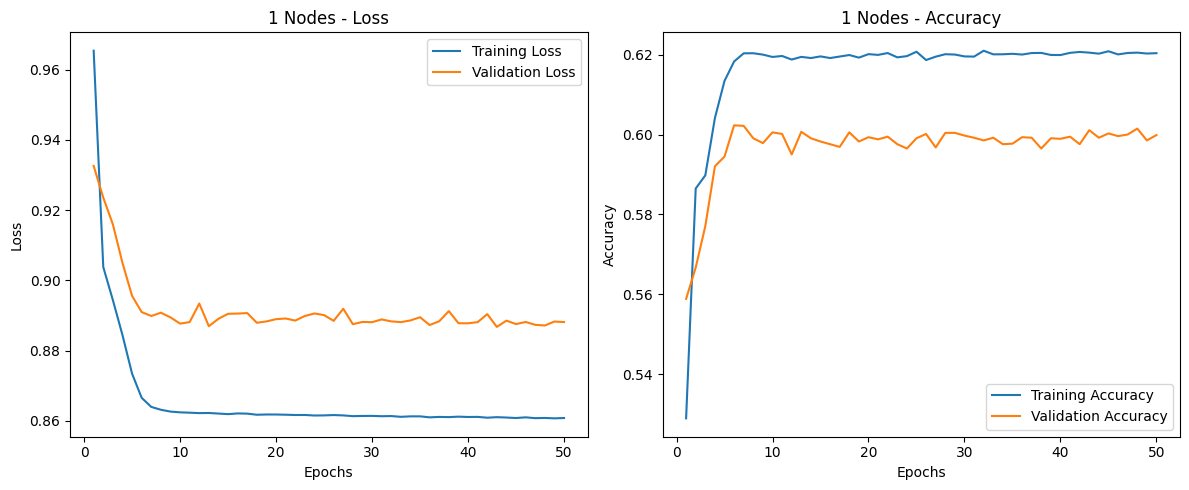


Training with 2 nodes in the hidden layer


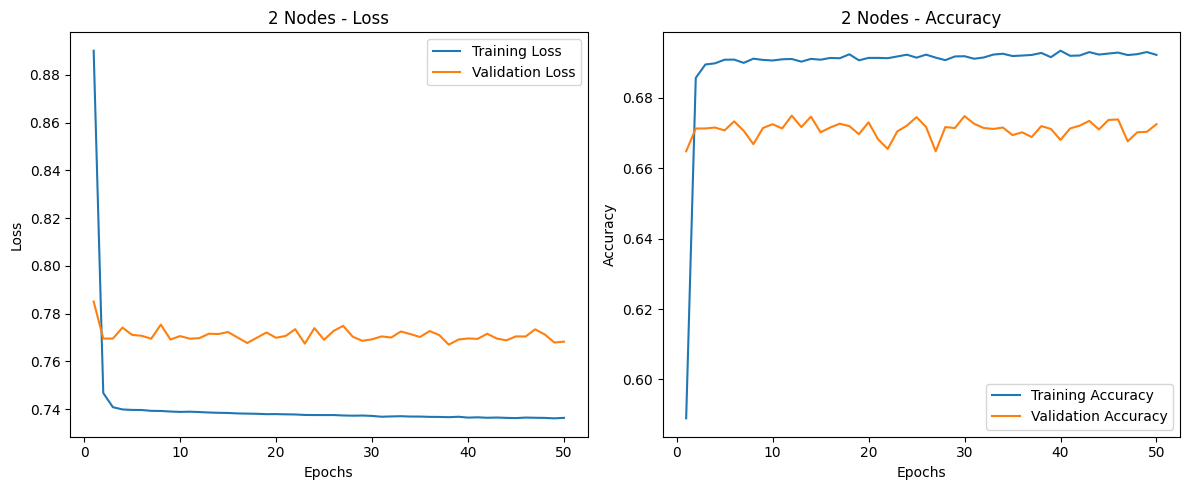


Training with 4 nodes in the hidden layer


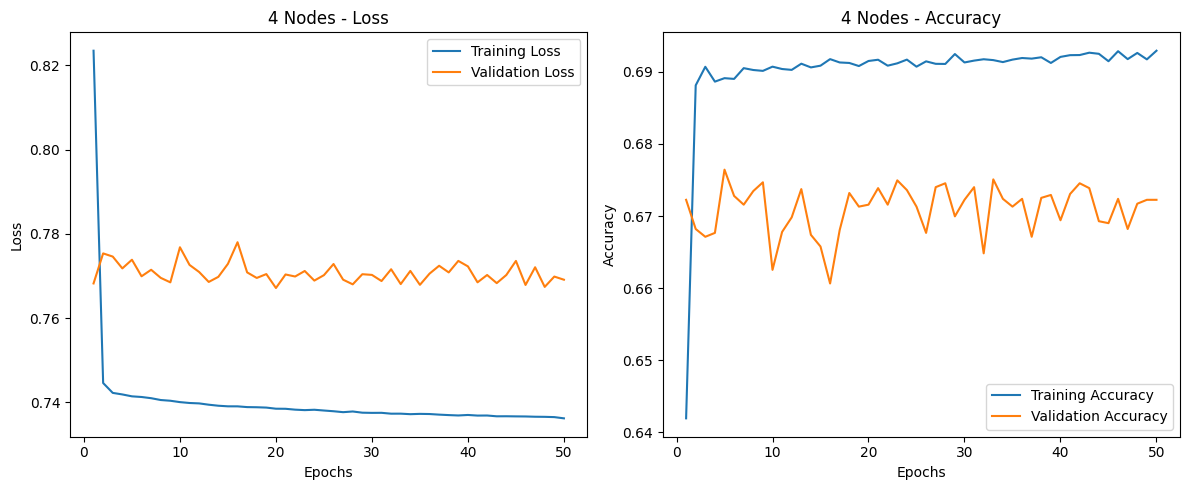


Training with 8 nodes in the hidden layer


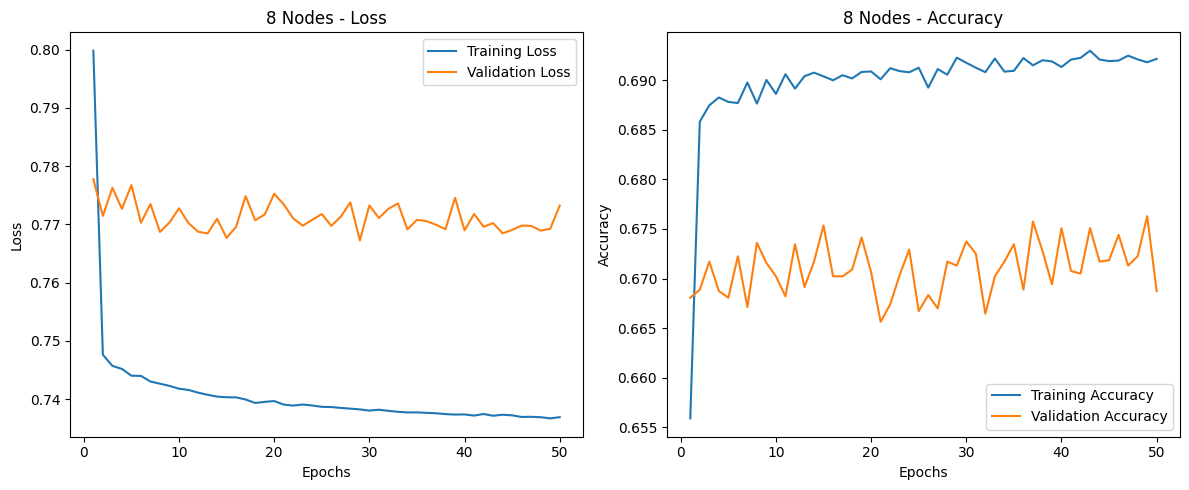


Training with 16 nodes in the hidden layer


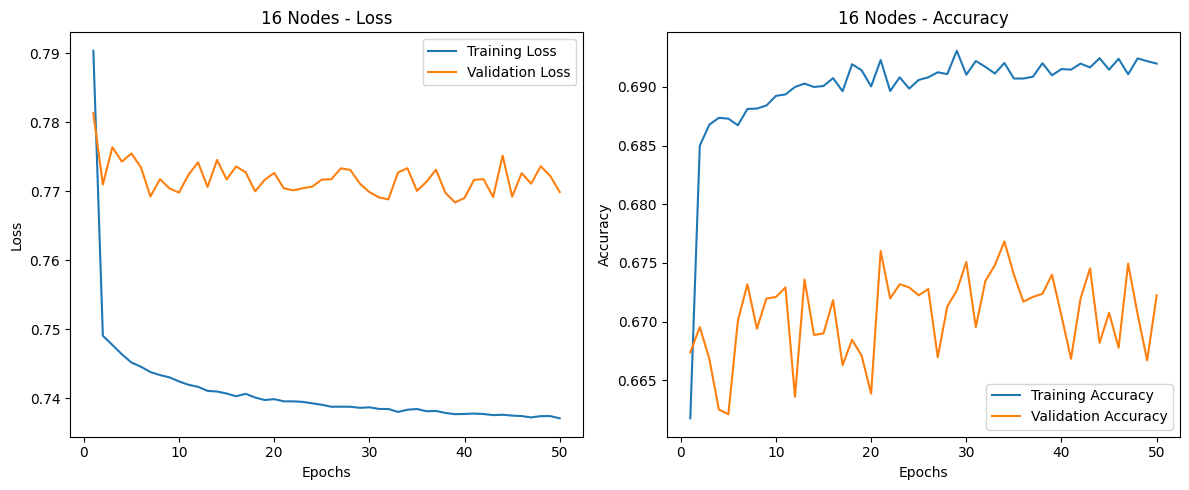


Training with 32 nodes in the hidden layer


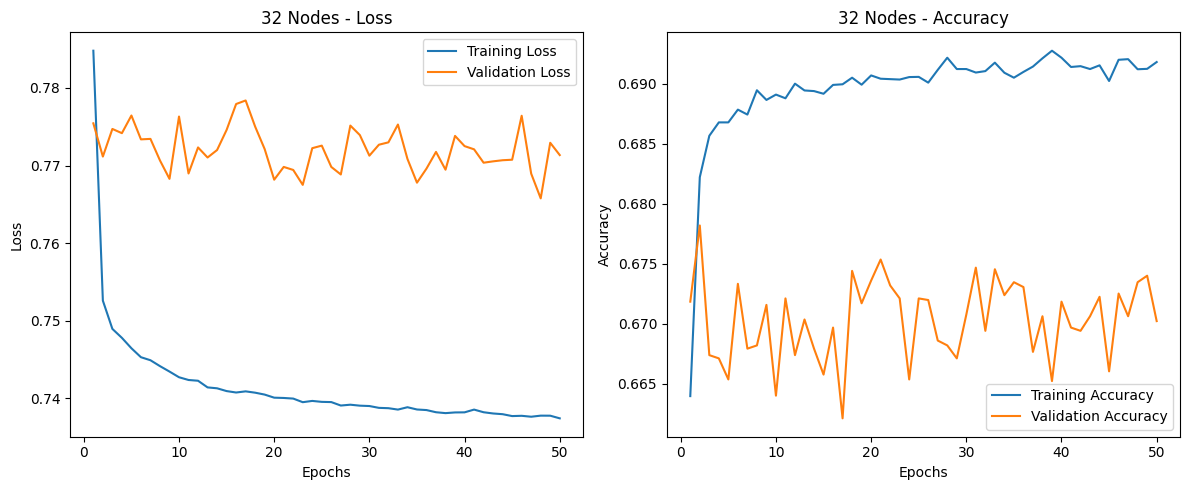


Training with 64 nodes in the hidden layer


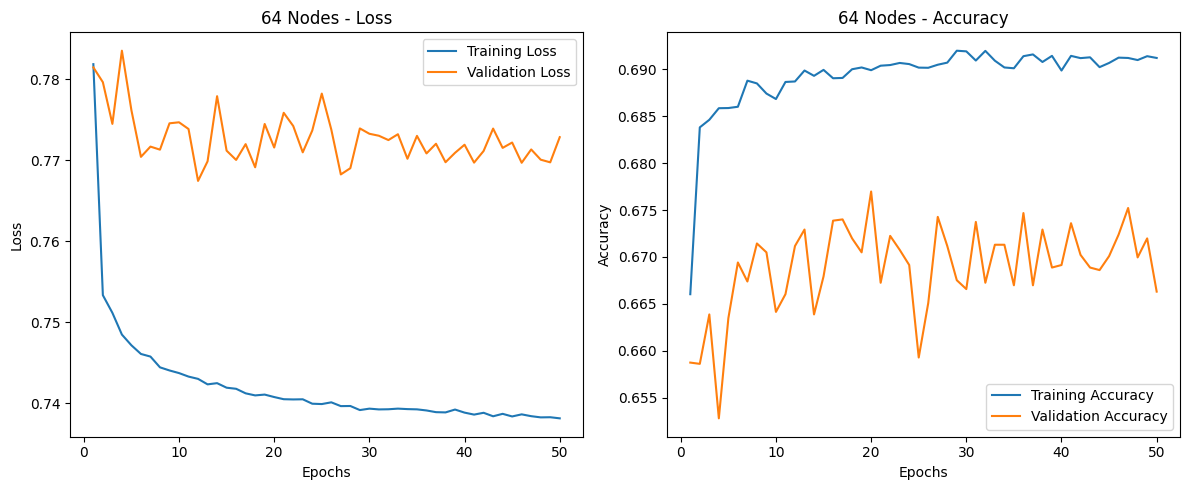


Training with 128 nodes in the hidden layer


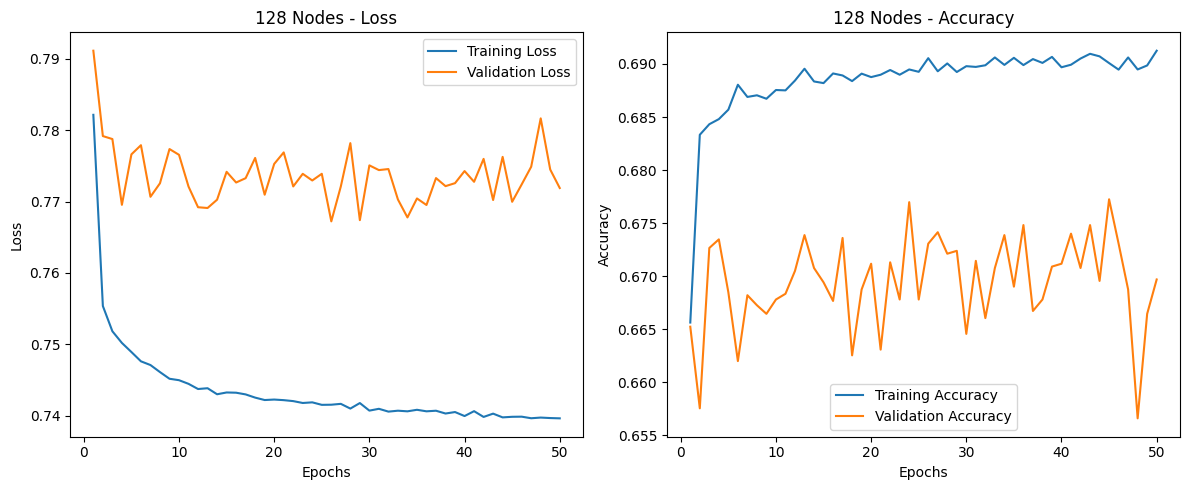


Training with 256 nodes in the hidden layer


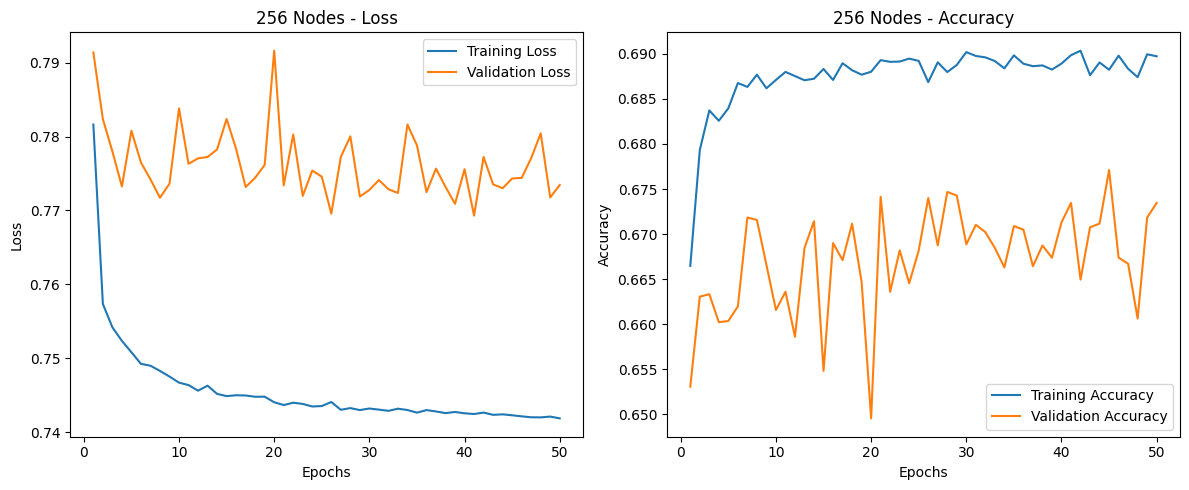


Training with 512 nodes in the hidden layer


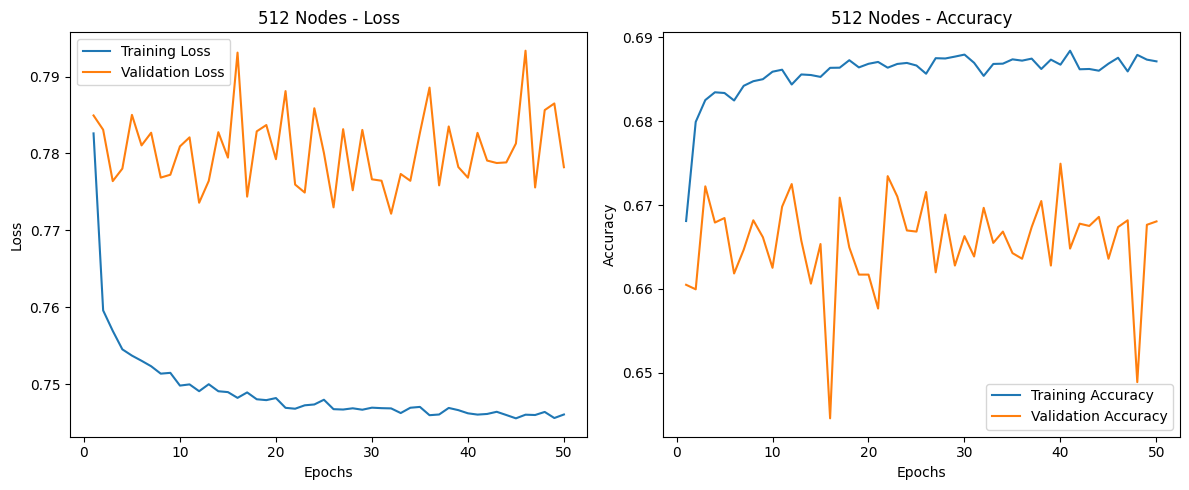

In [12]:
# Initialize lists to store histories for comparison
histories = {}

# Loop through different hidden layer node configurations
for nodes in [1, 2, 4, 8, 16, 32, 64, 128, 256, 512]:
    print(f"\nTraining with {nodes} nodes in the hidden layer")
    
    # Define model
    nn_model = Sequential([
        Input(shape=(462,)),              # Input layer
        Dense(nodes),                     # Hidden layer
        Dense(3, activation='softmax')    # Output layer with 3 classes
    ])

    # Compile model
    nn_model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])
    
    # Train model and store history
    history = nn_model.fit(X_train, y_train, epochs=50, validation_data=(X_valid, y_valid), verbose=0)
    histories[f'{nodes}_nodes'] = history

    # Plot results
    plot_loss_accuracy(history, title=f'{nodes} Nodes')

For this first experiment, I iterate through different numbers of nodes for the hidden layer to analyze performance, I start with one and progress to 512. So, for each iteration I define my model with the variable number of nodes for the hidden layer, compile the model, train the model and store the history so it can be graphed. I use 50 epochs for each experiment, I started with 5 or 10 as suggested and the model performed well, I then tested with 50 because I tested with 50 for a single node and thought it would be good to keep it consistent for all experiments, the assignment document also sayd epochs between 40 and 80 worked well, so I thought 50 was a good value to keep working with. For a single node, I can see a sharp decline and then plateau in training and validation loss, and a sharp increase and then plateau for training and validation accuracy. It seems for one node my model is underfitting, the training and validation losses both stabilize at relatively high values, and the gap between training and validation accuracy suggests the model is not capturing sufficient complexity to generalize well. This is likely due to the very low capacity (1 node) which limits its ability to learn patterns in the data. So this is good to know now that I will add more nodes. </br>
With 2 and 4 nodes in the hidden layer, the model shows a slight improvement in training performance, but there’s still a gap between training and validation accuracy, indicating some underfitting. The training loss consistently decreases to low values, while the validation loss remains higher and fluctuates, suggesting the model's limited capacity to capture enough complexity to generalize well. Increasing the node count helped marginally. </br>
I then continued to double the node count all the way until 512 nodes for the hidden layer, and what we can see in the end is that the training loss continued to decrease significantly, indicating the model’s improved capacity to fit the training data. However, the validation loss and accuracy fluctuate widely and show no consistent improvement, which suggests the model may now be overfitting, it captures the training data well but struggles to generalize to new data. </br>
What I am also able to see, is that with 50 training epochs, I was able to eventually see an increase in validation loss for 512 nodes. The validation loss finished as higher than when the model began, so this epoch count was sufficient to show this increase. Overall, this experiment showed me the profound impact of varying the nodes for the hidden layer, I will now move on to the next experiment which is varying the number of layers.

#### 9. Model Comparison


--------------------------------------------------------------------------

### References
[Matplotlib Pyplot Documentation](https://matplotlib.org/3.5.3/api/_as_gen/matplotlib.pyplot.html)<br/>
[Numpy User Guide](https://numpy.org/devdocs/user/)<br/>
[Pandas User Guide](https://pandas.pydata.org/docs/user_guide/index.html) <br/>
[Seaborn User Guide](https://seaborn.pydata.org/tutorial/introduction.html)<br/>
[Sklearn Linear Model Documentation](https://scikit-learn.org/stable/modules/linear_model.html)<br/>
[Sklearn Metrics Documentation](https://scikit-learn.org/stable/api/sklearn.metrics.html)<br/>
[Sklearn Model Selection Documentation](https://scikit-learn.org/stable/api/sklearn.model_selection.html)<br/>
[Sklearn Neighbors Documentation](https://scikit-learn.org/stable/modules/neighbors.html)<br/>
[Sklearn Preprocessing Documentation](https://scikit-learn.org/stable/modules/preprocessing.html)<br/>
[Sklearn Tree Documentation](https://scikit-learn.org/stable/modules/tree.html)<br/>
<br/>
Most of my reference came from my own first assignment since a lot of the techniques were able to be used for this assignment as well. For the newer concepts I referred to the documentation and the course lecture notes to see how to implement them. 